In [1]:
from dataset import banglachar
from models import resnet_transformer
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
import torchmetrics

FileNotFoundError: Could not find module 'C:\Users\Salekin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchaudio\lib\libtorchaudio.pyd' (or one of its dependencies). Try using the full path with constructor syntax.

In [ ]:
import metadata.char as metadata
m = metadata.MAPPING
def show_label(t):
    label_length = len(t)
    label = []
    for i in range(label_length):
        idx = t[i].item()
        label.append(m[idx])    
    label = ''.join(char for char in label if char != '<P>')
    print(label) 

In [ ]:
train_loader,test_loader,val_loader = banglachar.dividing_datasets(with_start_end_token=True)

জ্জু


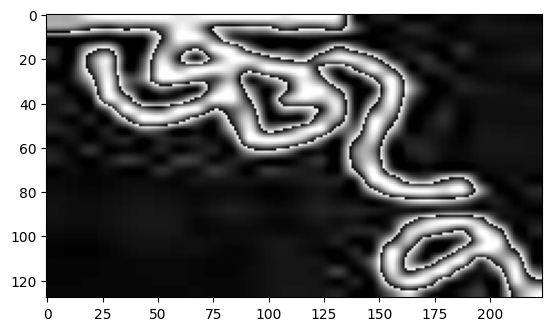

In [ ]:
idx = 30032

img = train_loader.dataset[idx]['images']
target = train_loader.dataset[idx]['targets']
show_label(target)
tensor_to_pil = transforms.ToPILImage()
pil_image = tensor_to_pil(img)
plt.imshow(pil_image)
plt.show()

In [ ]:
inverse_mapping = {val: ind for ind, val in enumerate(m)}
start_index = inverse_mapping["<S>"]
end_index = inverse_mapping["<E>"]
padding_index = inverse_mapping["<P>"]

ignore_tokens = [start_index, end_index, padding_index]

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=padding_index)


class CharacterErrorRate(torchmetrics.CharErrorRate):
    def __init__(self, ignore_tokens):
        super().__init__()
        self.ignore_tokens = set(ignore_tokens)

    def update(self, preds, targets):  # type: ignore
        preds_l = [[t for t in pred if t not in self.ignore_tokens] for pred in preds.tolist()]
        targets_l = [[t for t in target if t not in self.ignore_tokens] for target in targets.tolist()]
        super().update(preds_l, targets_l)

In [ ]:
def teacher_forward(model, x, y):
    """Uses provided sequence y as guide for non-autoregressive encoding-decoding of x.

    Parameters
    ----------
    x
        Batch of images to be encoded. See self.model.encode for shape information.
    y
        Batch of ground truth output sequences.

    Returns
    -------
    torch.Tensor
        (B, C, Sy) logits
    """
    x = model.encode(x)
    output = model.decode(x, y)  # (Sy, B, C)
    return output.permute(1, 2, 0)  # (B, C, Sy)


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'  
cer = CharacterErrorRate(ignore_tokens) 
 
def train_fn(model, data_loader, optimiser):
    model.train()
    fin_loss = 0
    for _, data in enumerate(data_loader):
        images, targets = data['images'], data['targets']
        x = images.to(device)
        y = targets.to(device)
        logits = teacher_forward(model,x, y[:, :-1])
        optimiser.zero_grad()
        loss = loss_fn(logits, y[:, 1:])
        loss.backward()
        optimiser.step()
        fin_loss += loss.item()
    return fin_loss/len(data_loader)     
   
def eval_fn(model, data_loader):
    model.eval()
    fin_loss = 0
    with torch.no_grad():
        
        for _, data in enumerate(data_loader):
            images, targets = data['images'], data['targets']
            x = images.to(device)
            y = targets.to(device)
            logits = teacher_forward(model,x, y[:, :-1])
            loss = loss_fn(logits, y[:, 1:])
            fin_loss += loss.item()
            preds = model(x)
            val_cer = cer(preds,y)
        return val_cer,fin_loss/len(data_loader)       

C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torchmetrics\utilities\prints.py:61: FutureWarning: Importing `CharErrorRate` from `torchmetrics` was deprecated and will be removed in 2.0. Import `CharErrorRate` from `torchmetrics.text` instead.
  _future_warning(


In [ ]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'  
print(device)
print(torch.cuda.device_count())
    

cpu
0


In [ ]:
model = resnet_transformer.ResnetTransformer().to(device)

optimiser = torch.optim.Adam(model.parameters(), lr = 1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimiser, mode='min', factor=0.8, patience=5 ,verbose=True
)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
    

train_losses = []
valid_losses = []
for epoch in range(10):
    train_loss = train_fn(model,train_loader,optimiser)
    valid_cer,valid_loss = eval_fn(model,val_loader)
    print(f"Epoch {epoch}:\nTrain loss: {train_loss}\nval loss: {valid_loss}, val cer: {valid_cer}")
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    scheduler.step(valid_loss)

C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\torch\nn\functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 0:
Train loss: nan
val loss: 8.318334662425299, val cer: 3.4285714626312256
Epoch 1:
Train loss: nan
val loss: 6.126893425932025, val cer: 3.344085931777954
Epoch 2:
Train loss: nan
val loss: 5.116606189641454, val cer: 2.961164951324463
Epoch 3:
Train loss: nan
val loss: 5.098015472946275, val cer: 2.923076868057251


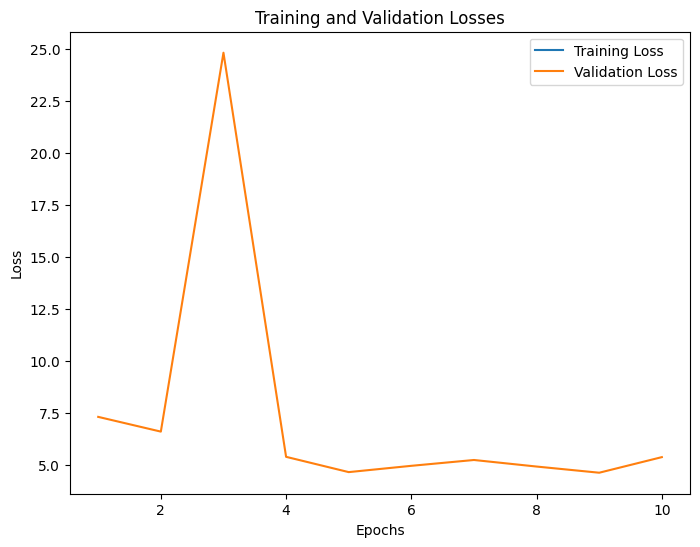

In [ ]:
epochs = range(1, 10 + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()    